# Notebook for Programming Question 1
Welcome to the programming portion of the assignment! you will be using [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true), so if you have never used it before, take a quick look through this introduction: [Working with Google Colab](https://docs.google.com/document/d/1LlnXoOblXwW3YX-0yG_5seTXJsb3kRdMMRYqs8Qqum4/edit?usp=sharing).

you be also be programming in Python, which we will assume a basic familiarity with. Python has fantastic community support and we'll be using numerous packages for machine learning (ML) and natural language processing (NLP) tasks.

### Learning Objectives
In this problem we will experiment with language models and implement smoothing. We will also see effects of using unigram/bigram LMs and the size of the training data.

### Writing Code
Look for the keyword "TODO" and fill in your code in the empty space.
Feel free to add and delete arguments in function signatures, but be careful that you might need to change them in function calls which are already present in the notebook.

### Data preprocessing

In this section we will write code to load data and clean (tokenize) it.

In [50]:
# Import libraries for preprocessing
import os
import numpy as np
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Rob\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [51]:
# Tokenizer class
# Fill all function blocks marked as TODO

class Tokenizer:
  def __init__(self, tokenize_type='basic', lowercase=False):
    self.lowercase = lowercase  # If this is True, convert text to lowercase while tokenizing.
    self.type = tokenize_type
    self.vocab = []


  """This simple tokenizer splits the text using whitespace."""
  def basicTokenize(self, string):
    words = string.split()
    return words

  ### TODO : Fill in this function to use NLTK's word_tokenize() function. ###
  def nltkTokenize(self, string):
    ##### SOLUTION START #####
    if self.lowercase:
      string = string.lower()
    return nltk.word_tokenize(string)
    ##### SOLUTION END #####
    
  def tokenize(self, string):
    if self.lowercase:
      string = string.lower()
    if self.type == 'basic':
      tokens = self.basicTokenize(string)
    elif self.type == 'nltk':
      tokens = self.nltkTokenize(string)
    else:
      raise ValueError('Unknown tokenization type.')


    # Populate vocabulary
    self.vocab += [w for w in set(tokens) if w not in self.vocab]

    return tokens

  ### TODO: Fill in this function to return the top k words (and their frequency) in the corpus according to frequency. ###
  def countTopWords(self, words, k):
    ##### SOLUTION START #####
    fdist = nltk.FreqDist(word.lower() for word in words)
    return fdist.most_common(k)
    ##### SOLUTION END #####

In [52]:
# Function for reading the corpus
def readCorpus(filename, tokenizer):
  with open(filename) as f:
    words = tokenizer.tokenize(f.read())
  return words

### Language Modeling and Smoothing
In this section we will first compute the bigram counts and estimate bigram probabilities. We will then implement add-alpha smoothing to modify the probabilities.

In [53]:
# Import libraries
# Feel free to import as many as you like
import sys
import os
import numpy as np
import argparse
from tqdm import tqdm
from collections import Counter

In [54]:
# Class definition for language modeling
# Fill all function blocks marked as TODO

class LanguageModel:
  def __init__(self, vocab, n=2, smoothing=None, smoothing_param=None):
    assert n >=2, "This code does not allow you to train unigram models."
    self.vocab = vocab
    self.token_to_idx = {word: i for i, word in enumerate(self.vocab)}
    self.n = n
    self.smoothing = smoothing
    self.smoothing_param = smoothing_param
    self.bi_counts = None      # Holds the bigram counts
    self.bi_prob = None        # Holds the computed bigram probabilities.

    assert smoothing is None or smoothing_param is not None, "Forgot to specify a smoothing parameter?"


  """Compute basic bigram probabilities (without any smoothing)"""
  def computeBigramProb(self):
    self.bi_prob = self.bi_counts.copy()

    for i, _ in enumerate(tqdm(self.bi_prob, desc="Estimating bigram probabilities")):
      cnt = np.sum(self.bi_prob[i])
      if cnt > 0:
        self.bi_prob[i] /= cnt

  ### TODO: complete ###
  def computeBigramProbAddAlpha(self, alpha=0.001):
    ##### SOLUTION START #####
    self.bi_prob = self.bi_counts.copy()
    vocab_size = self.bi_counts.shape[1]

    for i, _ in enumerate(tqdm(self.bi_prob, desc="Estimating bigram probabilities with additive alpha")):
      cnt = np.sum(self.bi_prob[i])
      self.bi_prob[i] = (self.bi_prob[i] + alpha) / (cnt + alpha * vocab_size)
    ##### SOLUTION END #####
    return


  """Train a basic n-gram language model"""
  def train(self, corpus):
    if self.n==2:
      self.bi_counts = np.zeros((len(self.vocab), len(self.vocab)), dtype=float)
    else:
      raise ValueError("Only bigram model has been implemented so far.")

    # Convert to token indices.
    corpus = [self.token_to_idx[w] for w in corpus]

    # Gather counts
    for i, idx in enumerate(tqdm(corpus[:1-self.n], desc="Counting")):
      self.bi_counts[idx][corpus[i+1]] += 1

    # Pre-compute the probabilities.
    if not self.smoothing:
      self.computeBigramProb()
    elif self.smoothing == 'addAlpha':
      self.computeBigramProbAddAlpha(self.smoothing_param)
    else:
      raise ValueError("Unknown smoothing type.")



  def test(self, corpus):
    logprob = 0.

    # Convert to token indices.
    corpus = [self.token_to_idx[w] for w in corpus]

    for i, idx in enumerate(tqdm(corpus[:1-self.n], desc="Evaluating")):
      logprob += np.log(self.bi_prob[idx, corpus[i+1]])

    # import pdb; pdb.set_trace()

    logprob /= len(corpus[:1-self.n])

    # Compute perplexity
    ppl = np.exp(-logprob)

    return ppl

### Instantiate a tokenizer and LM, and calculate perplexity
This section contains driver code for learning a language model and evaluating it on a train and dev corpus.

In [55]:
def runLanguageModel(train_corpus,
                     val_corpus,
                     train_fraction,
                     tokenizer,
                     smoothing_type=None,
                     smoothing_param='0.0'):

  # Print the top 10 words in the corpus.
  # IMPORTANT: complete the function within the tokenizer class in data.py first.
  print("Top 10 words: %s" %(tokenizer.countTopWords(train_corpus, k=10)))

  # Instantiate the language model.
  lm = LanguageModel(tokenizer.vocab, n=2, smoothing=smoothing_type, smoothing_param=smoothing_param)

  # Figure out index for a specific percentage of train corpus to use.
  train_idx = int(train_fraction * len(train_corpus))

  lm.train(train_corpus[:train_idx])

  train_ppl = lm.test(train_corpus[:train_idx])
  val_ppl = lm.test(val_corpus)

  print("Train perplexity: %f, Val Perplexity: %f" %(train_ppl, val_ppl))

  return [train_ppl, val_ppl]

### Load the data

In [56]:
# Load training data here
# First download the datasets

#!wget https://github.com/Tsegaye-misikir/NLP-rug/blob/main/brown/brown-train.txt
#!wget https://github.com/Tsegaye-misikir/NLP-rug/blob/main/brown/brown-test.txt

# Instantiate a basic tokenizer
basic_tokenizer = Tokenizer(tokenize_type='basic', lowercase=True)
nltk_tokenizer = Tokenizer(tokenize_type='nltk', lowercase=True)


# Read the corpus and store
train_corpus = readCorpus('brown-train.txt', basic_tokenizer)
val_corpus = readCorpus('brown-test.txt', basic_tokenizer)
train_corpus_nltk = readCorpus('brown-train.txt', nltk_tokenizer)
val_corpus_nltk = readCorpus('brown-test.txt', nltk_tokenizer)

### Experiments
Code for part a. Compare top 10 most common words between tokenizers 

In [66]:
print(f"Most common words nltk: {nltk_tokenizer.countTopWords(train_corpus_nltk, 10)}")
print(f"Most common words basic: {basic_tokenizer.countTopWords(train_corpus, 10)}")

Most common words nltk: [('the', 24657), (',', 22913), ('.', 22440), ('and', 10629), ('of', 10150), ('to', 9789), ('``', 9682), ('a', 8989), ('in', 6844), ('he', 6170)]
Most common words basic: [('the', 24657), (',', 22913), ('.', 22238), ('and', 10629), ('of', 10150), ('to', 9789), ('a', 8982), ('in', 6844), ('he', 5957), ('was', 5149)]


#### Plot the frequency of words
Code for sub-part (a)(b)

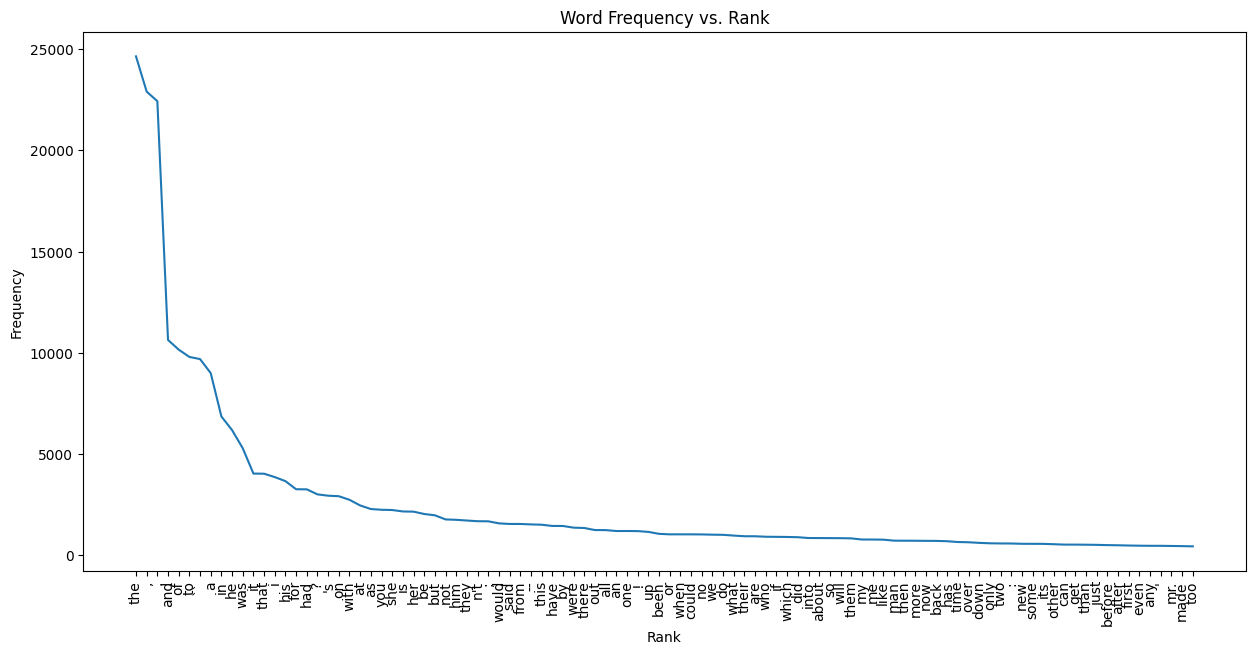

In [57]:
# TODO: Code for plotting the frequency of words
##### SOLUTION START #####
import matplotlib.pyplot as plt

most_common = nltk_tokenizer.countTopWords(train_corpus_nltk, 100)
words, frequencies = zip(*most_common)


# Plot the frequencies
plt.figure(figsize=(15, 7))
plt.plot(frequencies)
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Word Frequency vs. Rank')
plt.xticks(range(100), words, rotation='vertical')
plt.show()
##### SOLUTION END #####

#### Report the train and test perplexity after learning the language model
Code for sub-part (c)

In [60]:
# Train and test perplexity
runLanguageModel(train_corpus, val_corpus, train_fraction=1.0, tokenizer=basic_tokenizer)

Top 10 words: [('the', 24657), (',', 22913), ('.', 22238), ('and', 10629), ('of', 10150), ('to', 9789), ('a', 8982), ('in', 6844), ('he', 5957), ('was', 5149)]


Evaluating:   0%|          | 0/16869 [00:00<?, ?it/s]C:\Users\Rob\AppData\Local\Temp\ipykernel_11300\146427675.py:71: RuntimeWarning: divide by zero encountered in log
  logprob += np.log(self.bi_prob[idx, corpus[i+1]])
Evaluating: 100%|██████████| 16869/16869 [00:00<00:00, 210453.77it/s]


Train perplexity: 59.399107, Val Perplexity: inf


[np.float64(59.399107116841556), np.float64(inf)]

#### Add-alpha smoothing

In [67]:
# Example command
runLanguageModel(train_corpus, val_corpus, train_fraction=1.0, tokenizer=basic_tokenizer, smoothing_type='addAlpha', smoothing_param=0.01)

Top 10 words: [('the', 24657), (',', 22913), ('.', 22238), ('and', 10629), ('of', 10150), ('to', 9789), ('a', 8982), ('in', 6844), ('he', 5957), ('was', 5149)]


Counting: 100%|██████████| 446473/446473 [00:01<00:00, 330495.87it/s]
Estimating bigram probabilities with additive alpha: 100%|██████████| 29151/29151 [00:12<00:00, 2360.37it/s]
Evaluating: 100%|██████████| 16869/16869 [00:00<00:00, 152216.79it/s]


Train perplexity: 198.199459, Val Perplexity: 1378.856938


[np.float64(198.19945856393042), np.float64(1378.856937606149)]


Code for sub-part (d)

Top 10 words: [('the', 24657), (',', 22913), ('.', 22238), ('and', 10629), ('of', 10150), ('to', 9789), ('a', 8982), ('in', 6844), ('he', 5957), ('was', 5149)]


Counting: 100%|██████████| 446473/446473 [00:01<00:00, 346911.43it/s]
Estimating bigram probabilities with additive alpha: 100%|██████████| 29151/29151 [00:11<00:00, 2517.15it/s]
Evaluating: 100%|██████████| 16869/16869 [00:00<00:00, 138925.36it/s]


Train perplexity: 198.199459, Val Perplexity: 1378.856938
Top 10 words: [('the', 24657), (',', 22913), ('.', 22238), ('and', 10629), ('of', 10150), ('to', 9789), ('a', 8982), ('in', 6844), ('he', 5957), ('was', 5149)]


Counting: 100%|██████████| 446473/446473 [00:01<00:00, 386514.99it/s]
Estimating bigram probabilities with additive alpha: 100%|██████████| 29151/29151 [00:12<00:00, 2251.56it/s]
Evaluating: 100%|██████████| 16869/16869 [00:00<00:00, 53089.39it/s]


Train perplexity: 60.419416, Val Perplexity: 4791.749813
Top 10 words: [('the', 24657), (',', 22913), ('.', 22238), ('and', 10629), ('of', 10150), ('to', 9789), ('a', 8982), ('in', 6844), ('he', 5957), ('was', 5149)]


Counting: 100%|██████████| 446473/446473 [00:01<00:00, 399437.88it/s]
Estimating bigram probabilities with additive alpha: 100%|██████████| 29151/29151 [00:12<00:00, 2246.18it/s]
Evaluating: 100%|██████████| 16869/16869 [00:00<00:00, 143491.05it/s]


Train perplexity: 66.686065, Val Perplexity: 2489.659202
Top 10 words: [('the', 24657), (',', 22913), ('.', 22238), ('and', 10629), ('of', 10150), ('to', 9789), ('a', 8982), ('in', 6844), ('he', 5957), ('was', 5149)]


Counting: 100%|██████████| 446473/446473 [00:01<00:00, 395808.13it/s]
Estimating bigram probabilities with additive alpha: 100%|██████████| 29151/29151 [00:10<00:00, 2801.31it/s]
Evaluating: 100%|██████████| 16869/16869 [00:00<00:00, 177792.81it/s]


Train perplexity: 94.166602, Val Perplexity: 1570.592557
Top 10 words: [('the', 24657), (',', 22913), ('.', 22238), ('and', 10629), ('of', 10150), ('to', 9789), ('a', 8982), ('in', 6844), ('he', 5957), ('was', 5149)]


Counting: 100%|██████████| 446473/446473 [00:01<00:00, 412697.98it/s]
Estimating bigram probabilities with additive alpha: 100%|██████████| 29151/29151 [00:09<00:00, 2934.82it/s]
Evaluating: 100%|██████████| 16869/16869 [00:00<00:00, 182472.04it/s]


Train perplexity: 198.199459, Val Perplexity: 1378.856938
Top 10 words: [('the', 24657), (',', 22913), ('.', 22238), ('and', 10629), ('of', 10150), ('to', 9789), ('a', 8982), ('in', 6844), ('he', 5957), ('was', 5149)]


Counting: 100%|██████████| 446473/446473 [00:01<00:00, 388673.46it/s]
Estimating bigram probabilities with additive alpha: 100%|██████████| 29151/29151 [00:11<00:00, 2649.59it/s]
Evaluating: 100%|██████████| 16869/16869 [00:00<00:00, 169928.68it/s]


Train perplexity: 656.815243, Val Perplexity: 1897.221599
Top 10 words: [('the', 24657), (',', 22913), ('.', 22238), ('and', 10629), ('of', 10150), ('to', 9789), ('a', 8982), ('in', 6844), ('he', 5957), ('was', 5149)]


Counting: 100%|██████████| 446473/446473 [00:01<00:00, 406098.82it/s]
Estimating bigram probabilities with additive alpha: 100%|██████████| 29151/29151 [00:09<00:00, 3069.43it/s]
Evaluating: 100%|██████████| 16869/16869 [00:00<00:00, 173741.31it/s]


Train perplexity: 2964.240469, Val Perplexity: 4221.510495
Top 10 words: [('the', 24657), (',', 22913), ('.', 22238), ('and', 10629), ('of', 10150), ('to', 9789), ('a', 8982), ('in', 6844), ('he', 5957), ('was', 5149)]


Counting: 100%|██████████| 446473/446473 [00:01<00:00, 402490.17it/s]
Estimating bigram probabilities with additive alpha: 100%|██████████| 29151/29151 [00:10<00:00, 2779.03it/s]
Evaluating: 100%|██████████| 16869/16869 [00:00<00:00, 171828.24it/s]


Train perplexity: 10113.615387, Val Perplexity: 10616.468299


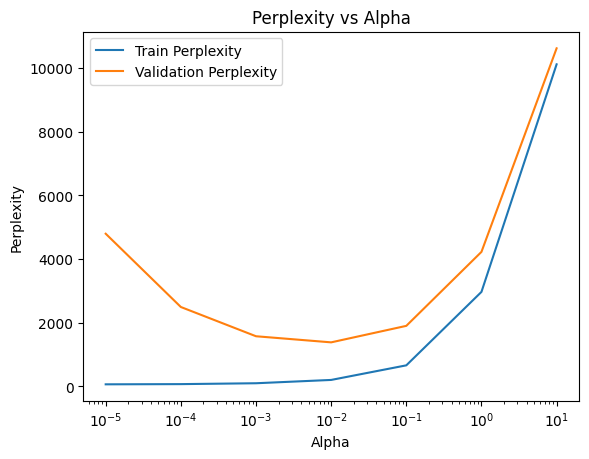

In [ ]:
# TODO: Part (d)
##### SOLUTION START #####
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
train_perplexities = []
val_perplexities = []

for alpha in alphas:
    train_ppl, val_ppl = runLanguageModel(train_corpus, val_corpus, train_fraction=1.0, tokenizer=basic_tokenizer, smoothing_type='addAlpha', smoothing_param=alpha)
    train_perplexities.append(train_ppl)
    val_perplexities.append(val_ppl)

plt.plot(alphas, train_perplexities, label='Train Perplexity')
plt.plot(alphas, val_perplexities, label='Validation Perplexity')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Perplexity')
plt.legend()
plt.title('Perplexity vs Alpha')
plt.show()

##### SOLUTION END #####